In [ ]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xf cifar-10-python.tar.gz

--2021-09-03 08:49:55--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  49.3MB/s    in 3.7s    

2021-09-03 08:49:59 (44.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
data_1 = unpickle('/content/cifar-10-batches-py/data_batch_1')

In [ ]:
data_1[b'data'].shape

(10000, 3072)

In [ ]:
data_1[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [ ]:
32*32

1024

170508288/170498071 [==============================] - 4s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


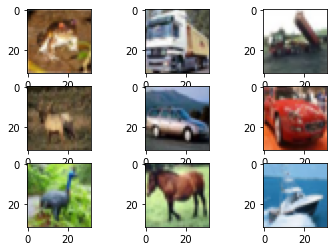

In [ ]:

# example of loading the cifar10 dataset
from matplotlib import pyplot
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

In [ ]:
import numpy as np
cirfar10 = np.concatenate([trainX,testX])
cirfar10_label = np.concatenate([trainy,testy])

In [ ]:
cirfar10.shape

(60000, 32, 32, 3)

In [ ]:
!mkdir -p ./images/cifar10/

In [ ]:
from PIL import Image
for index, image in enumerate(cirfar10) : 
  img = Image.fromarray(image, 'RGB')
  img.save('./images/cifar10/'+str(index)+'.png')
  # print(i.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import PIL.Image as Image
import shutil

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

device = 'cuda:0'

분석 대상 이미지들의 개수:  60000


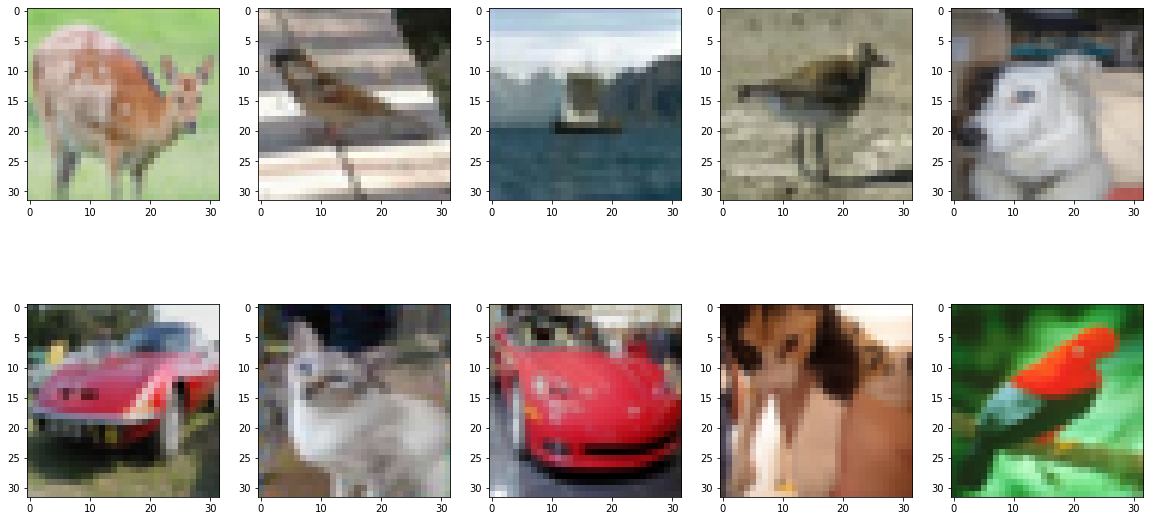

In [ ]:
img_path = os.path.join(os.getenv('HOME') , '/content/images/cifar10')
print('분석 대상 이미지들의 개수: ', len(os.listdir(img_path)))

fig = plt.figure(figsize=(20, 10))
columns = 5
rows = 2
for i in range(1, columns*rows +1):  # 샘플 10개 이미지만 골라서

    filename = os.listdir(img_path)[i]
    filepath = os.path.join(img_path, filename) # 파일 이름으로 읽고
    img = cv2.imread(filepath)[:,:,::-1] # 이미지로 읽은 후에 -> RGB 채널을 순서를 변경해주고

    fig.add_subplot(rows, columns, i)
    plt.imshow(img)# 이미지를 plotting 합니다
plt.show()

In [ ]:
sample_path = img_path + '/0.png' # path를 정의하고
sample_img = cv2.imread(sample_path) # opencv-python을 이용해서 이미지를 읽고

print(type(sample_img)) # nd.array 형태의
print(sample_img.shape) # height 1633 x width 1080 x channel 3 짜리 이미지가 나왔습니다

<class 'numpy.ndarray'>
(32, 32, 3)


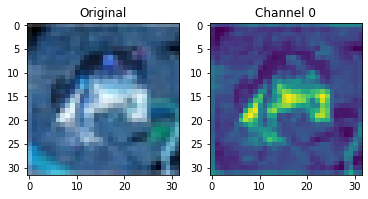

In [ ]:
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(sample_img)

plt.subplot(1,2,2)
plt.title('Channel 0')
channel_img = sample_img[:,:,0] # 0번째 채널 이미지
plt.imshow(channel_img)

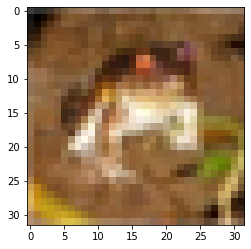

In [ ]:
sample_img_rgb = sample_img[:,:,::-1]
plt.imshow(sample_img_rgb)

In [ ]:
from PIL import Image

img = Image.fromarray(np.uint8(sample_img_rgb))

In [ ]:
# from torchvision import datasets, transforms

# center_cropper = transforms.Compose([
#     transforms.CenterCrop((224,224)),
# ])

# interpolater = transforms.Compose([
#     transforms.Resize((224,224), interpolation=Image.NEAREST)
# ])

# random_cropper = transforms.Compose([
#     transforms.RandomCrop((224,224))
# ])

# center_crop = center_cropper(img)
# interpolate = interpolater(img)
# random_crop = random_cropper(img)

# plt.figure(figsize=(13,5))
# plt.subplot(1,4,1)
# plt.title('Original')
# plt.imshow(img)

# plt.subplot(1,4,2)
# plt.title('Center Crop')
# plt.imshow(center_crop)

# plt.subplot(1,4,3)
# plt.title('Interpolate')
# plt.imshow(interpolate)

# plt.subplot(1,4,4)
# plt.title('Random Crop')
# plt.imshow(random_crop)

In [ ]:
# 1. image들에 대한 augmentation 정의하기
data_transforms = transforms.Compose([
    transforms.Resize((224,224),interpolation=Image.NEAREST), #BILINEAR, NEAREST, BICUBIC
    transforms.ToTensor(),
])

# 2. Dataloader 생성하기
def create_dataloader(path):
    
    # torch dataset으로 wrapping
    target_datasets = datasets.ImageFolder(path, transform=data_transforms)
    
    # dataloader로 wrapping return
    dataloader = torch.utils.data.DataLoader(
        target_datasets,
        shuffle=False
    )
    
    return dataloader

dataloader = create_dataloader(os.path.join(os.getenv('HOME') , '/content/images'))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6b8035fcee8d3a386de477d8fdbc4ce5d3b1de847d37723c6ede1b6921849ac5
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
net = EfficientNet.from_pretrained("efficientnet-b0", advprop=True, include_top=False)


In [ ]:
list(EfficientNet.from_name('efficientnet-b0', include_top=False).children())[-1]

MemoryEfficientSwish()

In [ ]:
# 3. 모델 정의하기
# net = torchvision.models.vgg16(pretrained=True)
net = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)

model = net

# model = torch.nn.Sequential(*(list(
#     net.children())[:5]),# avg_pool layer까지만 모델을 잘라줍니다
#     # list(EfficientNet.from_name('efficientnet-b0', include_top=False).children())[-1],
#     nn.Flatten()
# ) # avg_pool 에서 나온 layer를 flatten 하여, 분석에 용이한 2D Vector로 만들어줍니다

model.to(device) #모델은 gpu로 이동합니다.

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
# 4. model, dataloader를 input으로 제공한 이후, representation vector를 추출합니다
def provide_representations_sample(model, dataloader, size):

    representations = list()
    filenames = list()
    model.eval()

    for idx, (inputs, labels) in enumerate(dataloader):

        inputs = inputs.to(device)
        # outputs = model(inputs)
        outputs =  model.extract_features(inputs)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(outputs.shape[0],-1)
        
        filename, _ = dataloader.dataset.samples[idx]

        representations.append(outputs)
        filenames.append(filename)
        
        if idx > size-2 : 
            break

    representations = np.asarray(representations) # N x 1 x ?
    representations = np.squeeze(representations , axis=1) # dimension을 하나 줄여주고 -> N x ?
    
    filenames = np.asarray(filenames)
    
    return representations, filenames

In [ ]:
representations, filenames = provide_representations_sample(model, dataloader,1000)
print('Representation Shape: ', representations.shape)

Representation Shape:  (1000, 62720)


In [ ]:
# K-means Clustering 해보기
target_cluster_num = 10
kmeans = KMeans(n_clusters=target_cluster_num, random_state=0).fit(representations)

cluster_label = kmeans.predict(representations)

cluster  0


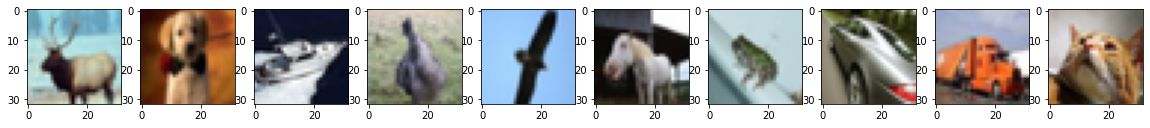

cluster  1


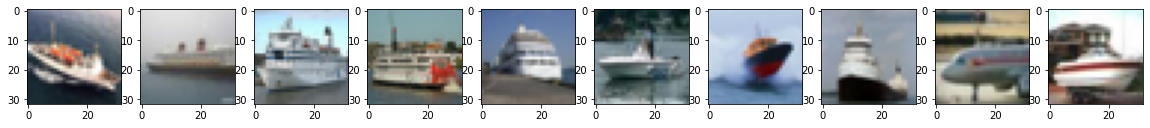

cluster  2


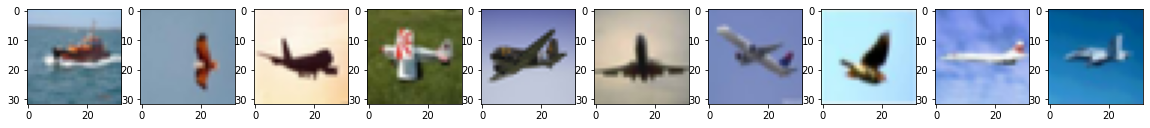

cluster  3


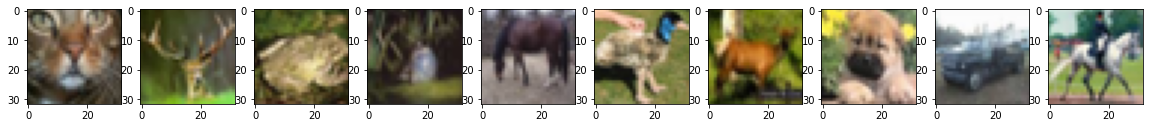

cluster  4


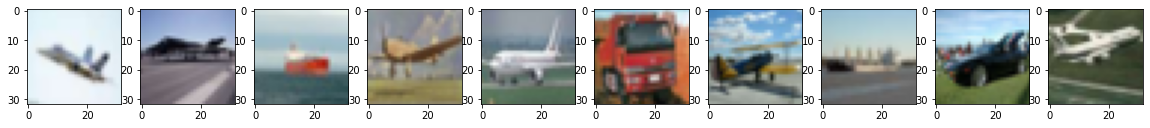

cluster  5


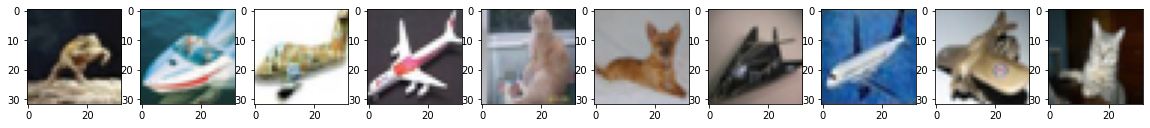

cluster  6


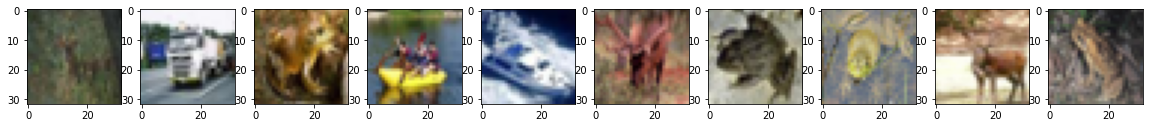

cluster  7


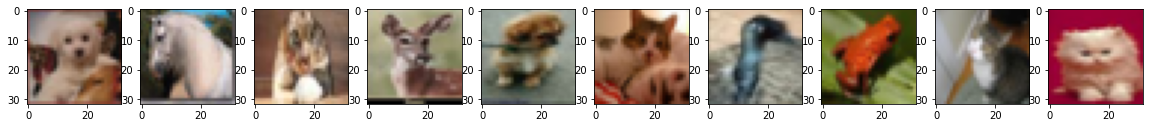

cluster  8


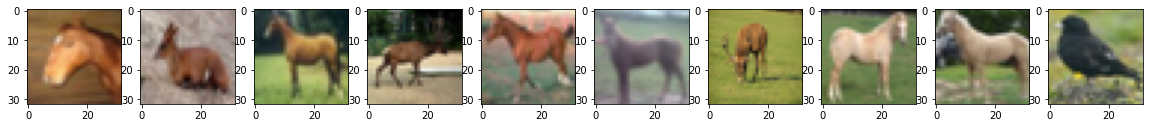

cluster  9


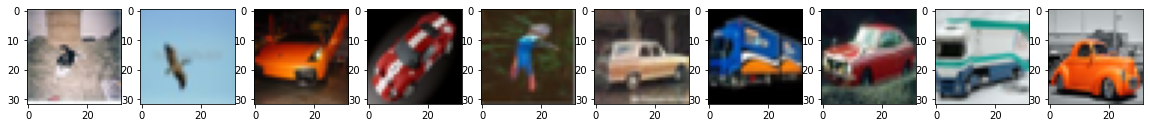

In [ ]:
for id in range(10) : 
  print("cluster ", id)
  print("="*135)
  selected_idxes = cluster_label==id
  selected_filenames = filenames[selected_idxes]

  fig = plt.figure(figsize=(20, 10))
  columns = 10
  rows = 1
  for i in range(1, columns*rows +1):  # 샘플 10개 이미지만 골라서
        try : 
          filepath = selected_filenames[i]
          img = cv2.imread(filepath)[:,:,::-1] # 이미지로 읽은 후에 -> RGB 채널을 순서를 변경해주고

          fig.add_subplot(rows, columns, i)
          plt.imshow(img)# 이미지를 plotting 합니다
        except : 
            pass
  plt.show()

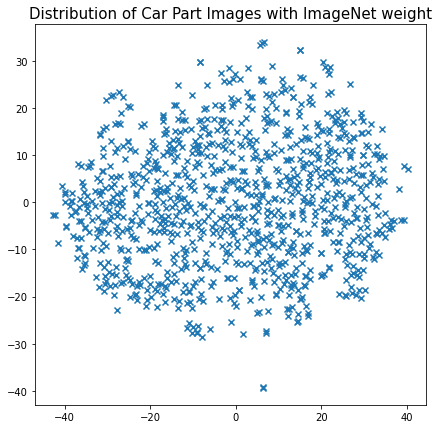

In [ ]:
# D. T-SNE로 차원축소해서 이미지들 사이의 representation에 차이가 있는지 확인해본다
x_embedded = TSNE(n_components=2).fit_transform(representations)

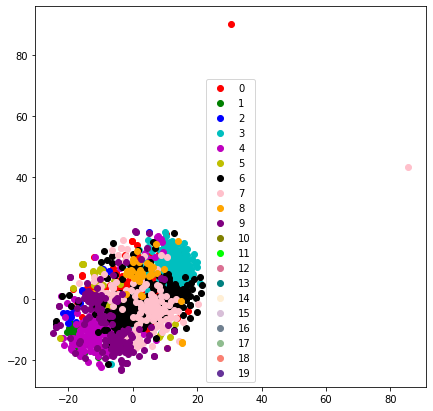

In [ ]:
#colored by k-means cluster
x_embedded = TSNE(n_components=2).fit_transform(representations)
target_ids = range(0,20)

from matplotlib import pyplot as plt
plt.figure(figsize=(7, 7))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple', 'olive', 'lime', 'palevioletred','teal', 'papayawhip', 'thistle', 'slategray', 'darkseagreen', 'salmon', 'rebeccapurple', 'beige'
for i, c, label in zip(target_ids, colors, target_ids):
    plt.scatter(x_embedded[cluster_label == i, 0], x_embedded[cluster_label == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [ ]:
def create_rotnet_set(base_dir, self_train_size, self_test_size):
    
    # Candidate Train, Test Filename 추출
    candidate_train_filenames, candidate_test_filenames = \
    path_to_train_test_filenames(base_dir, self_train_size, self_test_size)
    
    # Rotation 수행
    print('>> Start Making a Rotated Set...')
    save_base = os.path.join(base_dir, 'self_dataset', 'train_size_' + str(self_train_size))
    
    print('> Start Rotating Training Set...')
    train_save_dir = os.path.join(save_base, 'Training')
    if not os.path.exists(train_save_dir):
        os.makedirs(train_save_dir)
    rotate_and_save(candidate_train_filenames, train_save_dir)
        
    print('> Start Rotating Test Set...')
    test_save_dir = os.path.join(save_base, 'Test')
    if not os.path.exists(test_save_dir):
        os.makedirs(test_save_dir)
    rotate_and_save(candidate_test_filenames, test_save_dir)

In [ ]:
def path_to_train_test_filenames(base_dir, self_train_size, self_test_size):
    candidate_train_filenames = list()
    candidate_test_filenames = list()
    
    # 각 Class 별로 파일 이름 모으고
    target_src_path = os.path.join(base_dir, 'images')
    print('>>>>>>', target_src_path)
    print(os.listdir(target_src_path))
    
    for class_name in sorted(os.listdir(target_src_path)):
        
        class_path = os.path.join(target_src_path, class_name)
        class_test_filenames = sorted(os.listdir(class_path))[:self_test_size]
        class_train_filenames = sorted(os.listdir(class_path))[self_test_size : self_test_size+self_train_size]
        
        for class_filename in class_test_filenames:
            class_filepath = os.path.join(class_path, class_filename)
            candidate_test_filenames.append(class_filepath)
        
        for class_filename in class_train_filenames:
            class_filepath = os.path.join(class_path, class_filename)
            candidate_train_filenames.append(class_filepath)
            
    print('Train for Self: ', len(candidate_train_filenames))            
    print('Test for Self: ', len(candidate_test_filenames))
    
    return candidate_train_filenames, candidate_test_filenames

In [ ]:
def rotate_and_save(src_filenames, save_dir):
    rotation_list = [0, 90, 180, 270]
        
    for rotation_degree in rotation_list:
        print('> working on degree '+ str(rotation_degree))
        
        rot_save_dir = os.path.join(save_dir, 'degree_' + str(rotation_degree))
        if not os.path.exists(rot_save_dir):
            os.makedirs(rot_save_dir)

        for src_filename in src_filenames:

            img = cv2.imread(src_filename)
            rotated_img = image_rotator(img, rotation_degree)
    
            cv2.imwrite(os.path.join(rot_save_dir, src_filename.split('/')[-1]), rotated_img)

In [ ]:
def image_rotator(img, rotate_type):
    
    if rotate_type == 0:
        rotated_img = img
    
    elif rotate_type == 90:
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        
    elif rotate_type == 180:
        rotated_img = cv2.rotate(img, cv2.ROTATE_180)
        
    elif rotate_type == 270:
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
    else:
        raise ValueError

    return rotated_img

In [ ]:
# Self Supervised Learning 학습을 위한 Training / Test Set 생성하기
self_dataset_path = '/content/'
self_train_size = 50000
self_test_size = 10000

create_rotnet_set(self_dataset_path, self_train_size, self_test_size)

>>>>>> /content/images
['cifar10']
Train for Self:  50000
Test for Self:  10000
>> Start Making a Rotated Set...
> Start Rotating Training Set...
> working on degree 0
> working on degree 90
> working on degree 180
> working on degree 270
> Start Rotating Test Set...
> working on degree 0
> working on degree 90
> working on degree 180
> working on degree 270


In [ ]:
train_dir = '/content/self_dataset/train_size_'+str(self_train_size)+'/Training'
test_dir = '/content/self_dataset/train_size_'+str(self_train_size)+'/Test'


train_datasets = datasets.ImageFolder(train_dir, transform=data_transforms)
train_loaders = torch.utils.data.DataLoader(
    train_datasets,
    batch_size=128,
    shuffle=True,
)

test_datasets = datasets.ImageFolder(test_dir, transform=data_transforms)
test_loaders = torch.utils.data.DataLoader(
    test_datasets,
    shuffle=True,
)

dataloaders = {
    'train':train_loaders,
    'test':test_loaders
}

In [ ]:
pretext_model = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)
pretext_model._fc = nn.Linear(1280, 4)

Loaded pretrained weights for efficientnet-b0


In [ ]:
pretext_model._fc = nn.Linear(1280, 4)

Linear(in_features=1280, out_features=4, bias=True)

In [ ]:
pretext_model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.SGD(pretext_model.parameters(), lr=0.01)

In [ ]:
!mkdir ./models/

In [ ]:
num_epochs=20
# model = pretext_model

# train_acc_list =[]
# train_loss_list = []
# test_acc_list = []
# test_loss_list = []


# since = time.time()

# best_model_wts = copy.deepcopy(model.state_dict())
# best_acc = 0.0

for epoch in range(8,num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 20)

    # Each epoch has a training and validation phase
    for phase in ['train', 'test']:
        
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(labels)
            # print(labels.shape)
            # break
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
        print('>> Phase: ', phase)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

        if phase == 'train':
            train_acc_list.append(epoch_acc)
            train_loss_list.append(epoch_loss)
        else:
            test_acc_list.append(epoch_acc)
            test_loss_list.append(epoch_loss)

        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best test Acc: {:4f}'.format(best_acc))

# load best model weights
# model.load_state_dict(best_model_wts)

torch.save(best_model_wts , './models/pretrained_effb0_orignal_cifar10_50000_'+str(best_acc)+'.pt')

Epoch 8/19
--------------------
>> Phase:  train
train Loss: 0.1185 Acc: 0.9576
>> Phase:  test
test Loss: 0.1782 Acc: 0.9384
Epoch 9/19
--------------------
>> Phase:  train
train Loss: 0.1076 Acc: 0.9610
>> Phase:  test
test Loss: 0.1799 Acc: 0.9393
Epoch 10/19
--------------------
>> Phase:  train
train Loss: 0.0975 Acc: 0.9648
>> Phase:  test
test Loss: 0.1774 Acc: 0.9415
Epoch 11/19
--------------------
>> Phase:  train
train Loss: 0.0876 Acc: 0.9687
>> Phase:  test
test Loss: 0.1809 Acc: 0.9421
Epoch 12/19
--------------------
>> Phase:  train
train Loss: 0.0806 Acc: 0.9713
>> Phase:  test
test Loss: 0.1777 Acc: 0.9447
Epoch 13/19
--------------------
>> Phase:  train
train Loss: 0.0731 Acc: 0.9737
>> Phase:  test
test Loss: 0.1829 Acc: 0.9435
Epoch 14/19
--------------------
>> Phase:  train
train Loss: 0.0668 Acc: 0.9760
>> Phase:  test
test Loss: 0.1862 Acc: 0.9441
Epoch 15/19
--------------------
>> Phase:  train
train Loss: 0.0609 Acc: 0.9783
>> Phase:  test
test Loss: 0.189

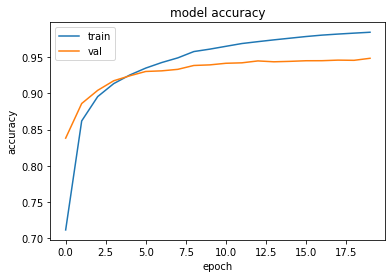

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

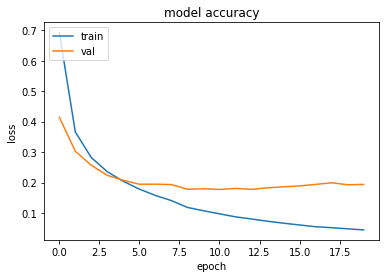

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
torch.save(best_model_wts , './models/pretrained_effb0_orignal_cifar10_50000.pt')

In [ ]:
# !mkdir ./models
mf_name = './models/pretrained_effb0_orignal_cifar10_50000_'+str(best_acc)+'.pt'
!gsutil cp ./models/ $mf_name gs://chem_dsrc/AttentiveFP/aiffel/socar/models/

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `gsutil cp ./models/ ./models/pretrained_effb0_orignal_cifar10_50000_tensor(0.9483, device='cuda:0', dtype=torch.float64).pt gs://chem_dsrc/AttentiveFP/aiffel/socar/models/'


In [ ]:
!mkdir ./models
!gsutil cp gs://chem_dsrc/AttentiveFP/aiffel/socar/models/pretrained_vgg_orignal_cifar10_50000.pt  ./models/

mkdir: cannot create directory ‘./models’: File exists
Copying gs://chem_dsrc/AttentiveFP/aiffel/socar/models/pretrained_vgg_orignal_cifar10_50000.pt...
- [1 files][512.2 MiB/512.2 MiB]   52.2 MiB/s                                   
Operation completed over 1 objects/512.2 MiB.                                    


In [ ]:
final_model = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)
final_model._fc = nn.Linear(1280, 4)
final_model.load_state_dict(torch.load(mf_name))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [ ]:
final_model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
# 4. model, dataloader를 input으로 제공한 이후, representation vector를 추출합니다
def provide_representations_sample(model, dataloader, size):

    representations = list()
    filenames = list()
    model.eval()

    for idx, (inputs, labels) in enumerate(dataloader):

        inputs = inputs.to(device)
        # outputs = model(inputs)
        outputs =  model.extract_features(inputs)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(outputs.shape[0],-1)
        
        filename, _ = dataloader.dataset.samples[idx]

        representations.append(outputs)
        filenames.append(filename)
        
        if idx > size-2 : 
            break

    representations = np.asarray(representations) # N x 1 x ?
    representations = np.squeeze(representations , axis=1) # dimension을 하나 줄여주고 -> N x ?
    
    filenames = np.asarray(filenames)
    
    return representations, filenames

In [ ]:
final_representations, filenames = provide_representations_sample(final_model, dataloader, 1000)

In [ ]:
print(final_representations.shape)
print(filenames.shape)

(1000, 62720)
(1000,)


In [ ]:
# E. Clustering 해보기

target_cluster_num = 10
final_kmeans = KMeans(n_clusters=target_cluster_num, random_state=0).fit(final_representations)

final_cluster_label = final_kmeans.predict(final_representations)

cluster  0


<Figure size 1440x720 with 0 Axes>

cluster  1


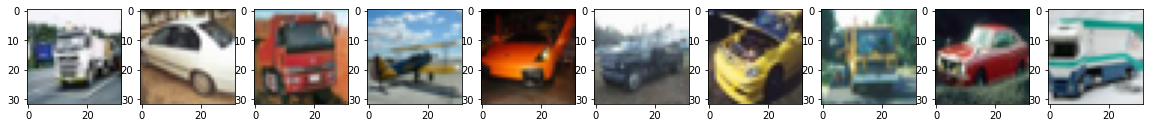

cluster  2


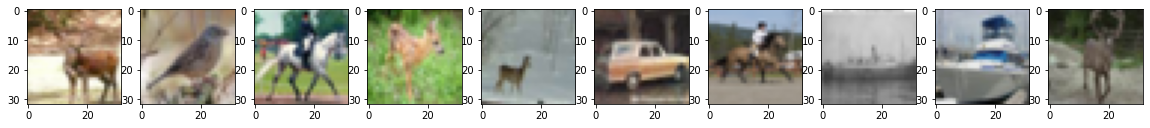

cluster  3


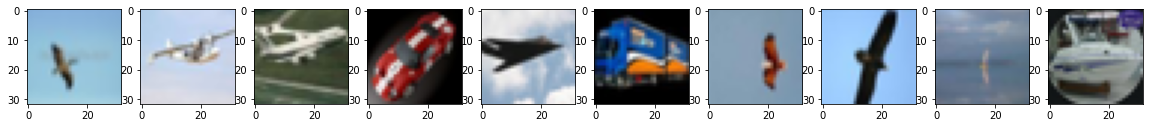

cluster  4


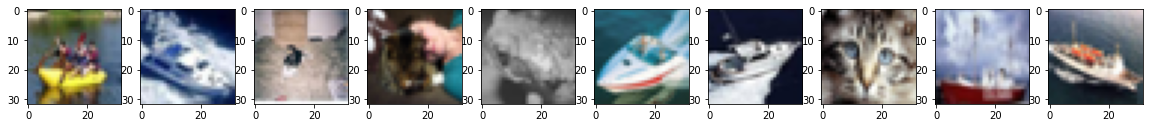

cluster  5


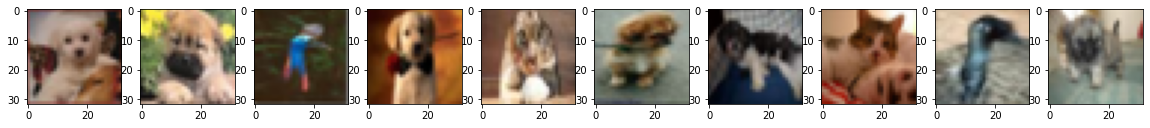

cluster  6


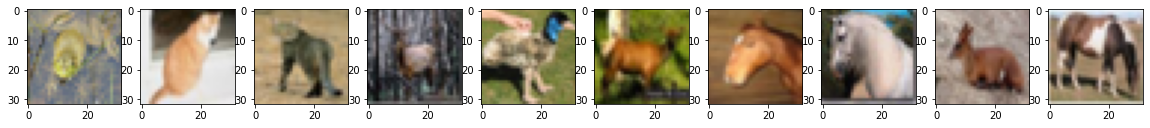

cluster  7


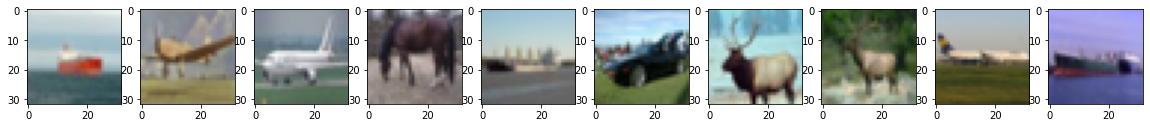

cluster  8


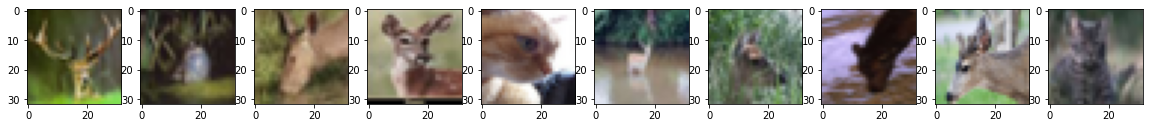

cluster  9


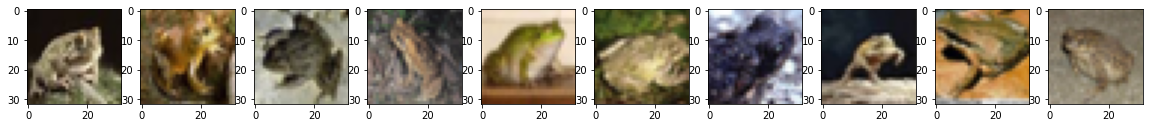

In [ ]:
for id in range(10) : 
  print("cluster ", id)
  print("="*135)
  final_selected_idxes = final_cluster_label==id
  final_selected_filenames = filenames[final_selected_idxes]

  fig = plt.figure(figsize=(20, 10))
  columns = 10
  rows = 1
  for i in range(1, columns*rows +1):  # 샘플 10개 이미지만 골라서
    try :
      filepath = final_selected_filenames[i]
      img = cv2.imread(filepath)[:,:,::-1] # 이미지로 읽은 후에 -> RGB 채널을 순서를 변경해주고

      fig.add_subplot(rows, columns, i)
      plt.imshow(img)# 이미지를 plotting 합니다
    except : 
      pass
  plt.show()

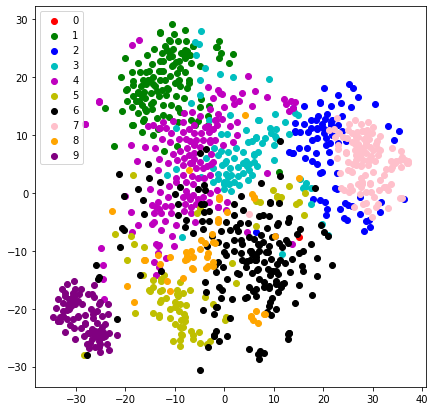

In [ ]:
# D. T-SNE로 차원축소해서 이미지들 사이의 representation에 차이가 있는지 확인해본다
x_embedded = TSNE(n_components=2).fit_transform(final_representations)

target_ids = range(0,10)

from matplotlib import pyplot as plt
plt.figure(figsize=(7, 7))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple', 'olive', 'lime', 'palevioletred','teal', 'papayawhip', 'thistle', 'slategray', 'darkseagreen', 'salmon', 'rebeccapurple', 'beige'
for i, c, label in zip(target_ids, colors, target_ids):
    plt.scatter(x_embedded[final_cluster_label == i, 0], x_embedded[final_cluster_label == i, 1], c=c, label=label)
plt.legend()
plt.show()